In [3]:
import sys
sys.path.append("/b2p")

In [ ]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import os
from glob import glob 
import rasterio
from rasterio import features
from rasterio.windows import Window
import geopandas as gpd
import numpy as np
import copy
from tqdm.notebook import tqdm 
import warnings
# filter out RuntimeWarnings, due to geopandas/fiona read file spam
# https://stackoverflow.com/questions/64995369/geopandas-warning-on-read-file
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [ ]:
from sklearn import preprocessing as p
def plotNormalizedImg(data, ax):
    min_max_scaler = p.MinMaxScaler()
    normalizedData = min_max_scaler.fit_transform(data.astype(np.float64))*255

    normalizedData = np.round(normalizedData).astype(np.uint8)
    
    ax.imshow(normalizedData)
    plt.show()
with rasterio.open('./data/test_composite/Rwanda/all/35MPS_multiband.tiff') as rf:
    fig, axs = plt.subplots(1,3)
    b2 = rf.read(1)
    b3 = rf.read(2)
    b4 = rf.read(3)
    plotNormalizedImg(b2, axs[0])
    print(np.isnan(b2).any())
    print(np.isnan(b3).any())
    print(np.isnan(b4).any())
    plotNormalizedImg(b3, axs[1])
    plotNormalizedImg(b4, axs[2])
    plt.show()

In [ ]:
# set inputs
s2_dir = '/b2p/data/tmp_s2/Rwanda/all'
bands = ['B02', 'B03','B04']
composite_dir = './data/test_composite'
dtype = np.float32
num_slices = 6

In [ ]:
with rasterio.open(outpath, 'w', driver='Gtiff', width=g_ncols, height=g_nrows, count=1, crs=crs,
                                   transform=transform, dtype=dtype) as wf:
        wf.write(median_corrected.astype(dtype), 1)

In [ ]:
from scipy.stats import norm
dif = np.diff(median_corrected, axis=1) # right col minus left
data = dif.mean(axis=0)
mu, std = norm.fit(data)
plt.subplots()
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [ ]:
from src.api.sentinel2 import SinergiseSentinelAPI

# Download New Data

In [ ]:
from src.api.sentinel2 import SinergiseSentinelAPI
buffer = 100
api = SinergiseSentinelAPI()

In [ ]:
# Rwanda (first month of dry szn)
bbox = [28.7869, -3.6889, 30.9732, -0.1978]
outdir = './data/tmp_s2/Rwanda/all'
start_date = '2018-06-01'
end_date = '2018-07-31'

In [ ]:
os.makedirs(outdir, exist_ok=True)
api.download(bbox, buffer, outdir, start_date, end_date)

In [ ]:
# Uganda
d_to_bbox = { Kabarole: [30.0675, 0.1847, 30.6141, 1.0581],
    Kasese: [29.4585, -0.7429, 30.5516, 1.0038],
    Ibanda: [30.1691, -0.4964, 30.7157, 0.3770]
}
for district, bbox in d_to_bbox.items():
    outdir = os.path.join('./data/tmp_s2/Rwanda', district)
    # get first dry szn
    start_date = '2019-06-15'
    end_date = '2019-08-15'
    os.makedirs(outdir, exist_ok=True)
    api.download(bbox, buffer, outdir, start_date, end_date)
    start_date = '2019-01-01'
    end_date = '2019-02-28'

# New way to Save Tiles

In [58]:
import torch
from torchvision.transforms import ToTensor
from osgeo import gdal
from src.utilities.coords import *

%matplotlib nbagg
import matplotlib.pyplot as plt
import os
from glob import glob 
import rasterio
from rasterio import features
from rasterio.windows import Window
import geopandas as gpd
import numpy as np
import copy
from tqdm.notebook import tqdm 
import warnings
import pandas as pd

In [ ]:
DIV = 300 # change from 366 for no cropping
def make_tile(multiband_tiff, tile_dir, bridge_locations, div:int=DIV): 
    assert os.path.isfile(multiband_tiff) 
    ## Load from composite
    image = None
    with rasterio.open(multiband_tiff, 'r') as rf:
        image = rf.read()
    tform = get_transform(tiff)
    src = gdla.Open(multiband_tiff)
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    
    ##
    _, xlen, ylen = image.shape

    xsteps = np.arange(0, xlen+div, div/xres)
    xsteps = [(xsteps[i], xsteps[i+1]-1) for i in range(len(xsteps)-1)]
    ysteps = np.arange(0, ylen+div, div/yres)
    ysteps = [(ysteps[i], ysteps[i+1]-1) for i in range(len(ysteps)-1)]

    _, multiband_tiff = os.path.split(multiband_tiff)
    military_prefix = multiband_tiff[-5:]
    tile_dir = os.path.join(tile_dir, military_prefix)
    if not os.path.isdir(tile_dir):
        os.makedirs(tile_dir)
        
    ## save the meta data to csv
    df = pd.DataFrame(
        columns=['tile', 'bbox', 'is_bridge', 'bridge_loc'],
        index=range(len(xsteps)*len(ysteps))
    )
    torchTformer = ToTensor()
    j = 0
    for xmin, xmax in xsteps:
        for ymin, ymax in ysteps:
            tile_basename = military_prefix +'_'+ str(i) + '_' + str(j) + '.pt'
            tile_filename =  os.path.join(tile_dir, tile_basename)
            tensor = torchTformer(image[:, xmin:xmax, ymin:ymax])
            torch.save(tensor, tile_filename)
            lrx = xmin + (src.RasterXSize * xres)
            lry = ymin + (src.RasterYSize * yres)


            ul = (ulx, uly)
            ll = (ulx, lry)
            ur = (lrx, uly)
            lr = (lrx, lry)
            bbox = lat_long_bbox((ul,ll,ur,lr), tform)
            df.at[j, 'tile']  = tile_filename
            df.at[j, 'bbox'] = bbox
            df.at[j, 'is_bridge']  = False 
            df.at[j, 'bridge_loc'] = None
            j += 1
            p = polygon.Polygon(bbox)
            for loc in bridge_locations: 
                # check if the current tiff tile contains the current verified bridge location
                if p.contains(loc):
                    df.at[j, 'is_bridge']  = True 
                    df.at[j, 'bridge_loc'] = loc
                    break
            

            
    df.to_csv(os.path.join(tile_dir, "geolocmetadata.csv"))

In [91]:
multiband_tiff = './data/composites/Rwanda/all/35MPS_multiband.tiff'
tile_dir = 'data/tmp_tile/Rwanda'
df = pd.read_csv('data/ground_truth/Rwanda.csv')
bridge_locations = [(df.loc[i, "Latitude"], df.loc[i,"Longitude"]) for i in range(len(df))]
# df["Latitude"]

In [128]:
image = None
with rasterio.open(multiband_tiff, 'r') as rf:
    image = rf.read()
tform = get_transform(multiband_tiff)
src = gdal.Open(multiband_tiff)
Lx, xres, xskew, Ty, yskew, yres = src.GetGeoTransform()

##
_, xlen, ylen = image.shape

xsteps = np.arange(0, xlen+div, div/xres)
xsteps = [(xsteps[i], xsteps[i+1]-1) for i in range(len(xsteps)-1)]
ysteps = np.arange(0, ylen+div, div/xres)
ysteps = [(ysteps[i], ysteps[i+1]-1) for i in range(len(ysteps)-1)]

_, fn = os.path.split(multiband_tiff)
military_prefix = fn[-5:]
m_dir = os.path.join(tile_dir, military_prefix)
if not os.path.isdir(m_dir):
    os.makedirs(m_dir)

In [168]:
i = 374
j = 0
xmin, xmax = xsteps[i]
ymin, ymax = ysteps[j]

lx = Lx + np.sign(xres) * i * div
ty = Ty + np.sign(yres) * j * div
rx = lx + np.sign(xres) * div
by = ty + np.sign(yres) * div
bbox = lat_long_bbox(
    (
        (lx, ty),
        (lx, by),
        (rx, ty),
        (rx, by)
    ), 
    tform
)


# torchTformer = ToTensor()
# tile_basename = military_prefix +'_lon'+ str(bbox[0]) + '_lat' + str(bbox[0]) + '.pt'
# tile_filename =  os.path.join(m_dir, tile_basename)
# tensor = torchTformer(image[:, xmin:xmax, ymin:ymax])
# torch.save(tensor, tile_filename)

In [169]:
rx

712500.0

In [117]:
tform.TransformPoint(*ul)

(-85.52611564603677, -63.23296179550032, 0.0)

In [110]:
tiff_to_bbox(multiband_tiff)

((-2.713837411553505, 27.899639974853475),
 (-3.707077536872182, 27.90050943338886),
 (-2.7126939034046416, 28.887178547109464),
 (-3.705514542831189, 28.88900139325669))

In [101]:
tform

<osgeo.osr.CoordinateTransformation; proxy of <Swig Object of type 'OSRCoordinateTransformationShadow *' at 0x7f3dff4b6450> >

In [158]:
lx, xres, xskew, ty, yskew, yres  = src.GetGeoTransform()
rx = lx + (src.RasterXSize * xres)
by = ty + (src.RasterYSize * yres)

tform = get_transform(multiband_tiff)

# Transform the point. You can also create an ogr geometry and use the more generic `point.Transform()`
# return transform.TransformPoint(ulx, uly)
tl = (lx, ty)
bl = (lx, by)
tr = (rx, ty)
br = (rx, by)
tform.TransformPoint(*tl)

(-2.713837411553505, 27.899639974853475, 0.0)

In [153]:
bl

(600000.0, 9699700.0)

In [122]:
lx

600000.0

In [154]:
xres

10.0

In [155]:
src.RasterXSize

10980

In [156]:
src.RasterXSize * xres

109800.0

In [176]:
from src.utilities import imaging
torchTformer = ToTensor()
tensor = torchTformer(imaging.scale(image).astype(np.uint8))
tensor

tensor([[[0.1333, 0.1333, 0.1451,  ..., 0.1255, 0.1176, 0.1255],
         [0.1961, 0.1961, 0.2118,  ..., 0.1843, 0.1882, 0.1882],
         [0.2549, 0.2549, 0.2588,  ..., 0.2392, 0.2353, 0.2353]],

        [[0.1333, 0.1333, 0.1333,  ..., 0.1294, 0.1216, 0.1216],
         [0.1961, 0.1961, 0.2000,  ..., 0.1922, 0.1882, 0.1843],
         [0.2549, 0.2549, 0.2549,  ..., 0.2392, 0.2353, 0.2392]],

        [[0.1373, 0.1373, 0.1373,  ..., 0.1294, 0.1255, 0.1255],
         [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1922, 0.1922],
         [0.2549, 0.2549, 0.2549,  ..., 0.2392, 0.2392, 0.2353]],

        ...,

        [[0.2118, 0.2118, 0.2118,  ..., 0.1569, 0.1569, 0.1608],
         [0.2275, 0.2275, 0.2353,  ..., 0.2078, 0.2118, 0.2078],
         [0.2510, 0.2510, 0.2549,  ..., 0.2039, 0.2078, 0.2078]],

        [[0.2118, 0.2118, 0.1922,  ..., 0.1608, 0.1569, 0.1608],
         [0.2275, 0.2275, 0.2196,  ..., 0.2118, 0.2118, 0.2078],
         [0.2471, 0.2471, 0.2431,  ..., 0.2118, 0.2078, 0.2039]],

 

In [175]:
imaging.scale(2500)

159.375

In [184]:
from bin import composites_to_tiles
from argparse import Namespace


In [216]:
df = composites_to_tiles.make_tiles(
    Namespace(
        multiband_tiff='./data/composites/Rwanda/all/36MTD_multiband.tiff', 
        tile_dir=tile_dir, 
        bridge_locations=composites_to_tiles.get_bridge_locations('data/ground_truth/')
    )
)

100%|██████████| 300/300 [15:41<00:00,  3.14s/it]


data/tmp_tile/Rwanda/36MTD/36MTD_3_122.pt
data/tmp_tile/Rwanda/36MTD/36MTD_12_101.pt
data/tmp_tile/Rwanda/36MTD/36MTD_13_91.pt
data/tmp_tile/Rwanda/36MTD/36MTD_74_115.pt


In [231]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import torchvision.transforms as T

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = T.ToPILImage(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

<IPython.core.display.Javascript object>


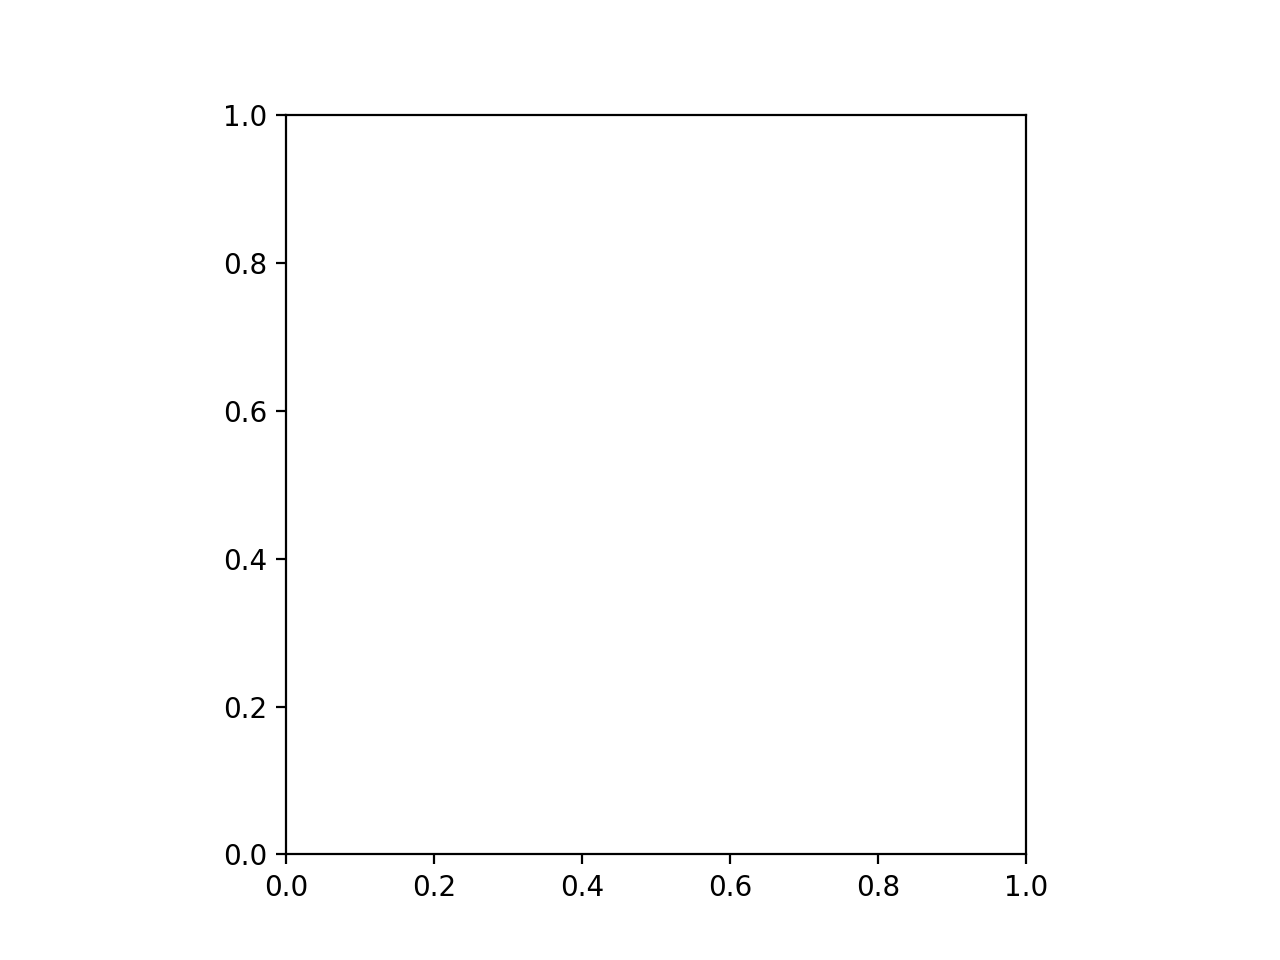

TypeError: Image data of dtype object cannot be converted to float

In [232]:
show(
    make_grid(
        [torch.load(tile) for tile in df.loc[df['is_bridge'], 'tile']]
    )
)

In [253]:
tiles = df.loc[df['is_bridge'], 'tile'].to_numpy()
tensor = torch.load(tiles[0])
img = tensor.nump
img
# fig, axs = plt.subplots(ncols=1, squeeze=False)
# axs[0,0].imshow(img)

ValueError: could not convert string to float: 'data/tmp_tile/Rwanda/36MTD/36MTD_3_122.pt'

In [215]:
from shapely.geometry import polygon
for tiff in glob('./data/composites/Rwanda/all/*.tiff'):
    bbox = tiff_to_bbox(tiff)
    bridge_locations=composites_to_tiles.get_bridge_locations('data/ground_truth/')
    p = polygon.Polygon(bbox)
    for loc in bridge_locations: 
        # check if the current tiff tile contains the current verified bridge location
        if p.contains(loc):
            print(tiff)
    #         df.at[j, 'bridge_loc'] = loc
            break

./data/composites/Rwanda/all/36MTD_multiband.tiff
./data/composites/Rwanda/all/36MTE_multiband.tiff
./data/composites/Rwanda/all/35MQT_multiband.tiff
./data/composites/Rwanda/all/35MQU_multiband.tiff
./data/composites/Rwanda/all/35MQV_multiband.tiff
./data/composites/Rwanda/all/35MRS_multiband.tiff
./data/composites/Rwanda/all/35MRT_multiband.tiff
./data/composites/Rwanda/all/35MRU_multiband.tiff
./data/composites/Rwanda/all/35MRV_multiband.tiff
./data/composites/Rwanda/all/36MTC_multiband.tiff
